In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load the RT-LBCI dataset
df = pd.read_csv('rt_lbci.csv')
df.head()

,date,value
0,2020-08-10,100.00
1,2020-08-17,103.20
2,2020-08-24,101.99
3,2020-08-31,101.32
4,2020-09-07,109.63


In [3]:
df.tail()

,date,value
235,2025-02-10,344.88
236,2025-02-17,395.95
237,2025-02-24,416.97
238,2025-03-03,370.00
239,2025-03-10,353.81


In [4]:
# Check number of rows and columns
df.shape

(240, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    240 non-null    object 
 1   value   240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


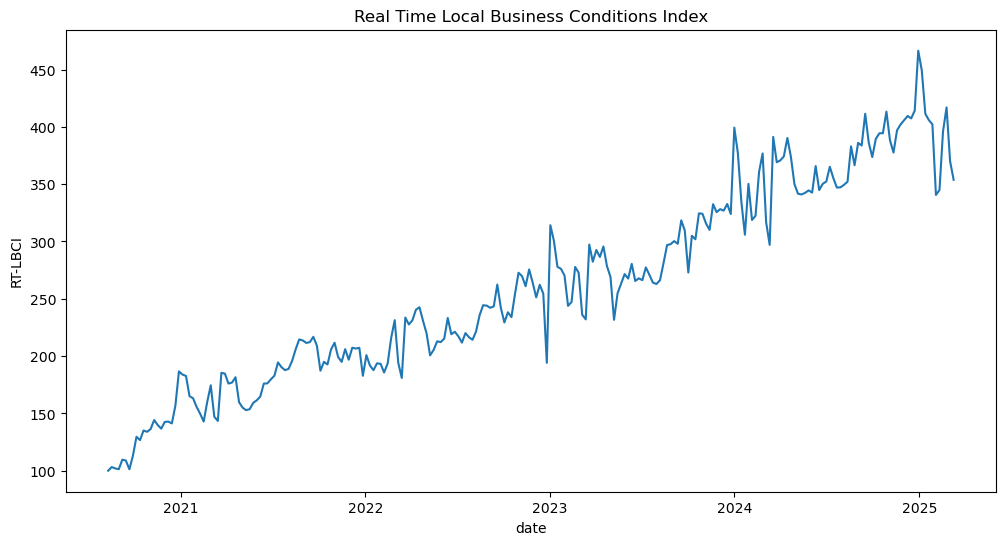

In [6]:
# convert 'date' column to date data type
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index
df.set_index('date', inplace=True)

# Plot the time series data
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='value')
plt.title('Real Time Local Business Conditions Index')
plt.ylabel('RT-LBCI')
plt.show()

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(df['value'], model='additive', period=12)  # Adjust period according to data

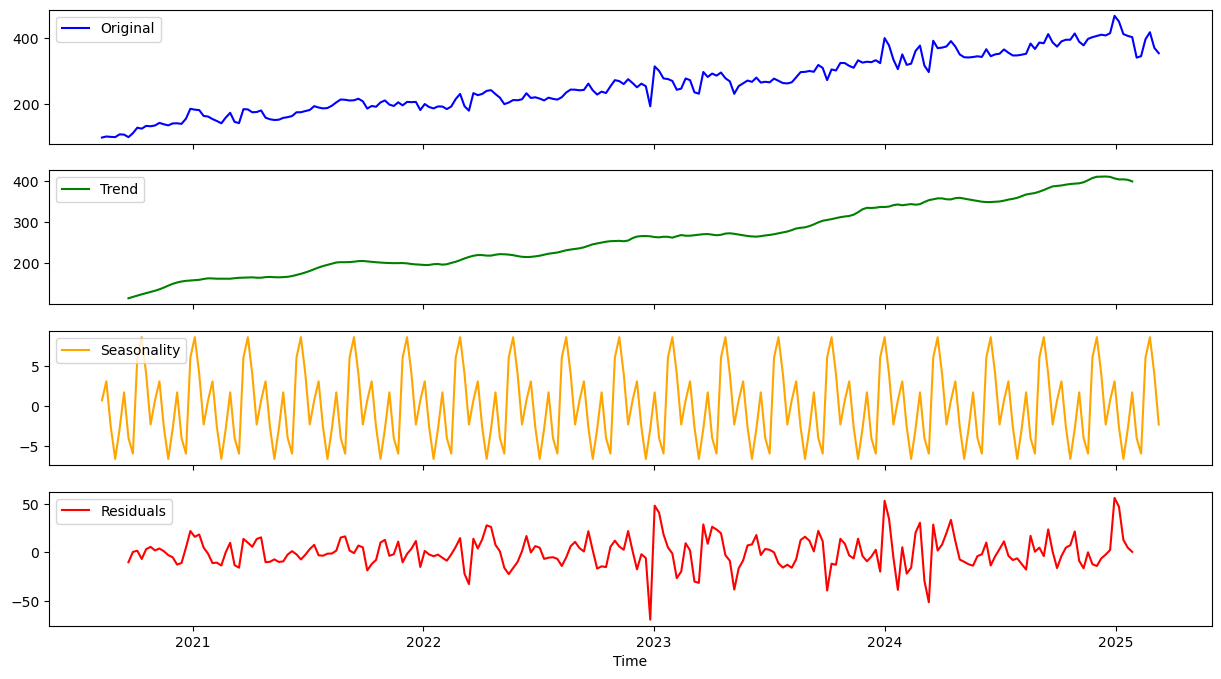

In [8]:
# Extract components
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

# Plot each component
fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
axes[0].plot(df['value'], label='Original', color='blue')
axes[0].legend(loc='upper left')
axes[1].plot(trend, label='Trend', color='green')
axes[1].legend(loc='upper left')
axes[2].plot(seasonal, label='Seasonality', color='orange')
axes[2].legend(loc='upper left')
axes[3].plot(residual, label='Residuals', color='red')
axes[3].legend(loc='upper left')
plt.xlabel('Time')
plt.show()

The chart above shows the Real Time Local Business Conditions Index (RT-LBCI) spanning from August 10, 2021 to March 10, 2025. Here's how it aligns with the time series components:

* **Trend**: The chart shows a strong upward trend, as the index steadily increases from around 100 in 2021 to over 400 by 2025, indicating an overall improvement in local business conditions during the time period.

* **Seasonality**: There are recurring fluctuations at consistent intervals, possibly representing seasonal effects that occur in business cycles—like periodic changes in consumer activity or economic influences.

* **Noise (Irregularity)**: Some variations in the data appear random and do not follow the overall trend or seasonality. These are likely irregularities caused by unforeseen events impacting business conditions.

* **Level**: The index starts at a baseline level of approximately 100 in 2021 and rises to a new level of over 400 by 2025, showing a significant shift in baseline business activity.

# Baseline Model 1 - Historical Mean

Our goal is to use the data from August 10, 2021 to Feb 10, 2025 (training dataset) to predict the values in next four weeks i.e. Feb 17, Feb 24, Mar 3, Mar 10, 2025 (test dataset).

The first baseline we’ll discuss uses the historical mean, which is the *arithmetic mean* of past values. Its implementation is straightforward: calculate the mean of the training set,
and it will be our prediction for the next 4 weeks.

To make the split, we’ll specify that our train set will contain all the data held in df except the last four entries. The test set will be composed of only the last four entries.

In [9]:
train = df[:-4]
test = df[-4:]

In [10]:
train

,value
date,
2020-08-10,100.00
2020-08-17,103.20
2020-08-24,101.99
2020-08-31,101.32
2020-09-07,109.63
...,...
2025-01-13,411.38
2025-01-20,405.86
2025-01-27,402.19


In [11]:
historical_mean = round(np.mean(train['value']), 2)
historical_mean

257.73

In [12]:
# Set the historical mean as a forecast
test.loc[:, 'pred_mean'] = historical_mean

Next, we need to define and calculate an error metric in order to evaluate the performance of our forecasts on the test set. In this case, we will use the mean absolute percentage error (MAPE). It is a measure of prediction accuracy for forecasting methods that is easy to interpret and independent of the scale of our data. This means that whether we are working with two-digit values or six-digit values, the MAPE will always be expressed as a percentage. Thus, the MAPE returns the percentage of how much the forecast values deviate from the observed or actual values on average, whether the prediction was higher or lower than the observed values.

In [13]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_hist_mean = round(mape(test['value'], test['pred_mean']), 2)
mape_hist_mean

32.65

Running the function gives a MAPE of 32.65%. This means that our baseline deviates by 32.65% on average from the observed weekly RT-LBCI values in the last 4 weeks.

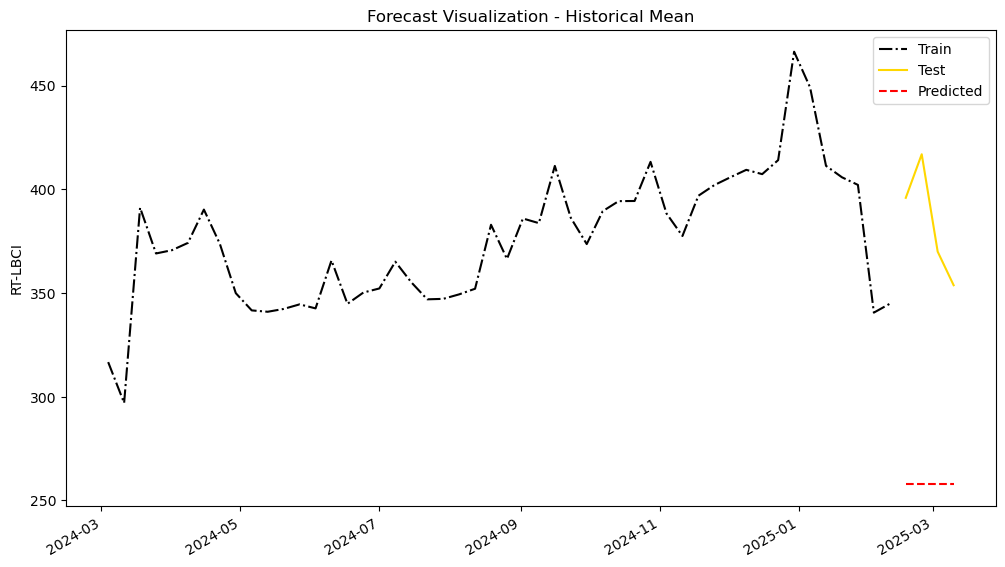

In [14]:
# Create the figure and axes with a wide figure size
fig, ax = plt.subplots(figsize=(12, 7))  # Adjust width and height as needed

# Plot the Train data
sns.lineplot(x='date', y='value', data=train[-50:], ax=ax, linestyle='-.', color='black', label='Train')

# Plot the Test data
sns.lineplot(x='date', y='value', data=test, ax=ax, color='gold', label='Test')

# Plot the Predicted data
sns.lineplot(x='date', y='pred_mean', data=test, ax=ax, linestyle='--', color='red', label='Predicted')

# Add labels and legend
ax.set(title='Forecast Visualization - Historical Mean', ylabel='RT-LBCI', xlabel = '')
ax.legend()
fig.autofmt_xdate()

# Show the plot
plt.show()


# Baseline Model 2 - Last year's mean

The lesson learned from the previous baseline is that earlier values do not seem to be predictive of future values in the long term because of the positive trend component in our dataset. Earlier values seem to be too small to be representative of the new level the RT-LBCI reaches in the last 4 weeks.

In [15]:
last_year_mean = round(np.mean(train.value[-12:]), 2)
last_year_mean

404.95

In [16]:
test.loc[:, 'pred__last_yr_mean'] = last_year_mean

In [17]:
mape_last_year_mean = round(mape(test['value'], test['pred__last_yr_mean']), 2)
mape_last_year_mean

7.26

This gives us a MAPE of 7.26%.

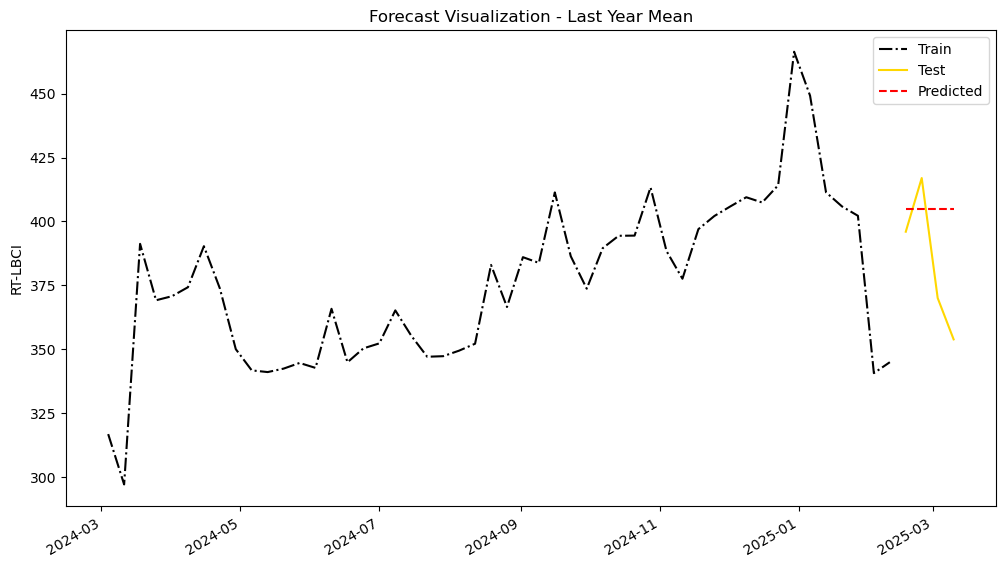

In [18]:
# Create the figure and axes with a wide figure size
fig, ax = plt.subplots(figsize=(12, 7))  # Adjust width and height as needed

# Plot the Train data
sns.lineplot(x='date', y='value', data=train[-50:], ax=ax, linestyle='-.', color='black', label='Train')

# Plot the Test data
sns.lineplot(x='date', y='value', data=test, ax=ax, color='gold', label='Test')

# Plot the Predicted data
sns.lineplot(x='date', y='pred__last_yr_mean', data=test, ax=ax, linestyle='--', color='red', label='Predicted')

# Add labels and legend
ax.set(title='Forecast Visualization - Last Year Mean', ylabel='RT-LBCI', xlabel = '')
ax.legend()
fig.autofmt_xdate()

# Show the plot
plt.show()

This new baseline is a clear improvement over the previous one, even though its implementation is just as simple, as we decreased the MAPE from 32.65% to 7.26%. This means that our forecasts deviate from the observed values by 7.26% on average. Using the last year’s mean is a good step in the right direction. We want to get a MAPE as close to 0% as possible, since that would translate into predictions that are closer to the actual values in our forecast horizon. We can learn from this baseline that future values likely depend on past values that are not too far back in history. This is a sign of autocorrelation.

# Baseline Model 3 - Predicting using the last known value

Previously we used the mean over different periods to develop a baseline model. So far, the best baseline has been the mean of the last recorded year in our training set, since it yielded the lowest MAPE. We learned from that baseline that future values depend on past values, but not those too far back in time.

Therefore, we could suppose that using the last known value of the training set as a baseline model will give us even better forecasts, which would translate to a MAPE closer to 0%.

In [19]:
last = train.value.iloc[-1]
last

344.88

In [20]:
test.loc[:, 'pred_last'] = last

In [21]:
mape_last = round(mape(test['value'], test['pred_last']), 2)
mape_last

9.88

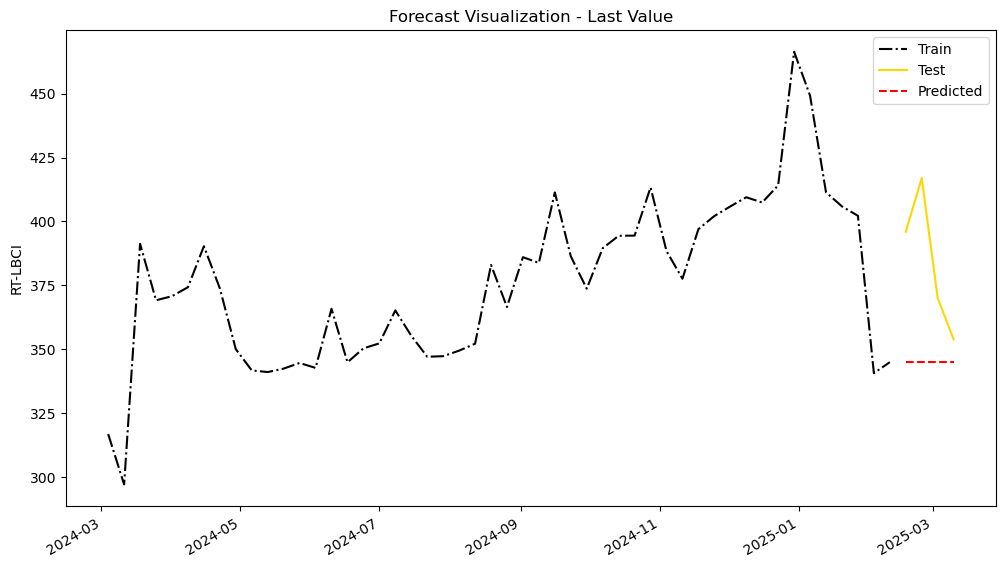

In [22]:
# Create the figure and axes with a wide figure size
fig, ax = plt.subplots(figsize=(12, 7))  # Adjust width and height as needed

# Plot the Train data
sns.lineplot(x='date', y='value', data=train[-50:], ax=ax, linestyle='-.', color='black', label='Train')

# Plot the Test data
sns.lineplot(x='date', y='value', data=test, ax=ax, color='gold', label='Test')

# Plot the Predicted data
sns.lineplot(x='date', y='pred_last', data=test, ax=ax, linestyle='--', color='red', label='Predicted')

# Add labels and legend
ax.set(title='Forecast Visualization - Last Value', ylabel='RT-LBCI', xlabel = '')
ax.legend()
fig.autofmt_xdate()

# Show the plot
plt.show()

It seems that our new hypothesis did not improve upon the last baseline that we built, since we have a MAPE of 9.88%, whereas we achieved a MAPE of 7.26% using the last year's mean. Therefore, these new forecasts are farther from the observed values.

# Baseline Model 4 - Naive Seasonal Forecast

There are clear cyclical patterns in our data, and that is a piece of information that we could use to construct one last baseline: the naive seasonal forecast. The naive seasonal forecast takes the last observed cycle and repeats it into the future. Let's just consider the last 4 weeks prior to test dataset to be the cycle.

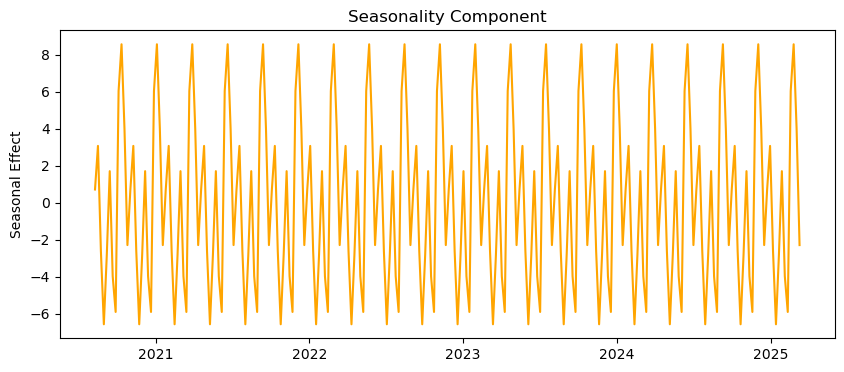

In [23]:
# Plot the seasonality component
plt.figure(figsize=(10, 4))  # Set figure size
plt.plot(seasonal, color='orange', label='Seasonality')
plt.title('Seasonality Component')
plt.xlabel('')
plt.ylabel('Seasonal Effect')
plt.show()


In [24]:
test.loc[:, 'pred_last_season'] = train['value'][-4:].values

In [25]:
mape_naive_seasonal = round(mape(test['value'], test['pred_last_season']), 2)
mape_naive_seasonal

4.13

This gives us a MAPE of 4.13%, which is the lowest MAPE from all the baselines.

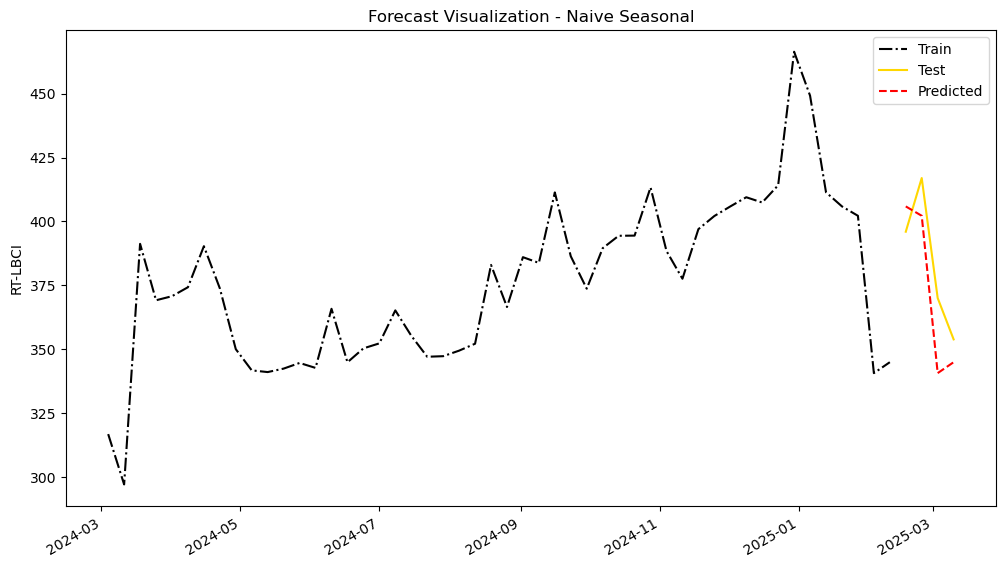

In [26]:
# Create the figure and axes with a wide figure size
fig, ax = plt.subplots(figsize=(12, 7))  # Adjust width and height as needed

# Plot the Train data
sns.lineplot(x='date', y='value', data=train[-50:], ax=ax, linestyle='-.', color='black', label='Train')

# Plot the Test data
sns.lineplot(x='date', y='value', data=test, ax=ax, color='gold', label='Test')

# Plot the Predicted data
sns.lineplot(x='date', y='pred_last_season', data=test, ax=ax, linestyle='--', color='red', label='Predicted')

# Add labels and legend
ax.set(title='Forecast Visualization - Naive Seasonal', ylabel='RT-LBCI', xlabel = '')
ax.legend()
fig.autofmt_xdate()

# Show the plot
plt.show()

This means that seasonality has a significant impact on future values, since repeating the last season into the future yields fairly accurate forecasts. Intuitively, this makes sense, because we can clearly observe a cyclical pattern being repeated. Seasonal effects will have to be considered when we develop a more complex forecasting model for this problem.

In [27]:
test

,value,pred_mean,pred__last_yr_mean,pred_last,pred_last_season
date,,,,,
2025-02-17,395.95,257.73,404.95,344.88,405.86
2025-02-24,416.97,257.73,404.95,344.88,402.19
2025-03-03,370.00,257.73,404.95,344.88,340.60
2025-03-10,353.81,257.73,404.95,344.88,344.88


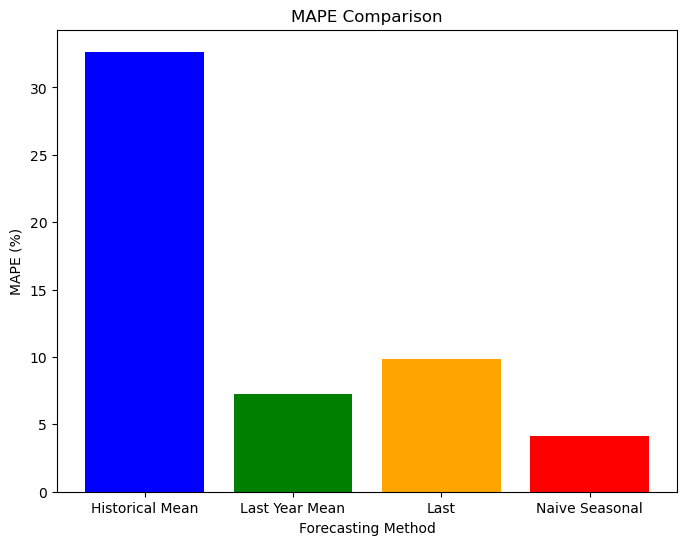

In [28]:
# Define the values and labels
mape_values = [mape_hist_mean, mape_last_year_mean, mape_last, mape_naive_seasonal]
labels = ['Historical Mean', 'Last Year Mean', 'Last', 'Naive Seasonal']

# Create the column chart
plt.figure(figsize=(8, 6))  # Set figure size
plt.bar(labels, mape_values, color=['blue', 'green', 'orange', 'red'])  # Customize bar colors
plt.title('MAPE Comparison')  # Chart title
plt.ylabel('MAPE (%)')  # Label y-axis
plt.xlabel('Forecasting Method')  # Label x-axis

# Display the chart
plt.show()
